# Generative Adversarial Networks (GANs)

Generative Adversarial Networks (GANs) were first proposed in the 2014 paper titled "[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)" and have been refined many times since. A GAN has two components: a generator that generates images from random noise, and a discriminator that classifies images generated by the generator as fake (0) or real (1). Training proceeds until the generator is sufficiently successful at generating images that fool the discriminator. Let's demonstrate how GANs are built and trained using MNIST digits. Begin by loading the dataset.

In [1]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


Plot the first 30 digits in the dataset.

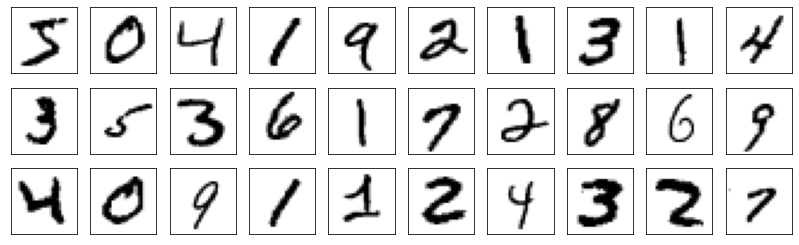

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 10, figsize=(14, 4.2), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i], cmap=plt.cm.gray_r)

Define one CNN to serve as a generator and another to serve as a discriminator. Then combine them to form a GAN.

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Reshape
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU

generator = Sequential()
generator.add(Dense(3 * 3 * 16))
generator.add(Reshape([3, 3, 16]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(32, (3, 3), activation='relu', strides=2)) #  7 x 7
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(16, (5, 5), activation='relu', strides=2, padding='same')) #  14 x 14
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, (5, 5), activation='tanh', strides=2, padding='same')) # 28 x 28

discriminator = Sequential()
discriminator.add(Conv2D(16, (5, 5), activation=LeakyReLU(0.2), strides=2, padding='same')) # 14 x 14
discriminator.add(Dropout(0.2))
discriminator.add(Conv2D(32, (5, 5), activation=LeakyReLU(0.2), strides=2, padding='same')) # 7 x 7
discriminator.add(Dropout(0.2))
discriminator.add(Conv2D(32, (3, 3), activation=LeakyReLU(0.2), strides=2, padding='same')) # 3 x 3
discriminator.add(Dropout(0.2))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

gan = Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='adam')

Use a custom training loop to train the model. In each epoch, the training images are shuffled and divided into batches. Then, for each batch, the discriminator is trained on a mixed batch of real and fake images with corresponding labels. Afterward, the model itself is trained on a batch of fake images whose labels are set to 1. This updates the generator's weights but not the discriminator's weights since `trainable=False` on the discriminator.

In [4]:
import time
import numpy as np

epochs = 50
batch_size = 32
input_size = 128
steps_per_epoch = x_train.shape[0] // batch_size

# Reshape the array containing the training images and condition the images
# for tanh activation by mutliplying each pixel value by 2 and subtracting 1
x_train_tanh = x_train.reshape(-1, 28, 28, 1) * 2 - 1

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs} ', end='')
    start_time = time.time() # Mark the start time

    # At the beginning of each epoch, shuffle the training images
    np.random.shuffle(x_train_tanh)
    
    for step in range(steps_per_epoch):
        # Fetch a batch of real images
        start = step * batch_size
        end = start + batch_size
        x_real = x_train_tanh[start:end]
        
        # Generate a batch of "fake" images
        noise = np.random.normal(size=(batch_size, input_size))
        x_fake = generator(noise) # Faster than calling predict()
        
        # Combine the real and fake images into a super batch and generate
        # labels for them (0 == fake, 1 == real)
        x = np.concatenate([x_real, x_fake])
        y = np.array([1] * batch_size + [0] * batch_size)
        
        # Train the discriminator with the mixed batch of images. Discriminator
        # weights get updated even though trainable=False.
        discriminator.train_on_batch(x, y)
        
        # Train the model with fake images generated by the generator. Set
        # all the labels to 1 even though the images aren't real to update the
        # generator's weights. The discriminator's weights don't get updated
        # because trainable=False.
        x = np.random.normal(size=(batch_size, input_size))
        y = np.array([1] * batch_size)
        gan.train_on_batch(x, y)
        
    time_diff = time.time() - start_time
    print(f'({time_diff:.1f} seconds)')

Epoch 1/50 (57.0 seconds)
Epoch 2/50 (55.2 seconds)
Epoch 3/50 (55.2 seconds)
Epoch 4/50 (54.5 seconds)
Epoch 5/50 (55.7 seconds)
Epoch 6/50 (55.0 seconds)
Epoch 7/50 (54.9 seconds)
Epoch 8/50 (55.1 seconds)
Epoch 9/50 (54.6 seconds)
Epoch 10/50 (56.4 seconds)
Epoch 11/50 (56.0 seconds)
Epoch 12/50 (56.0 seconds)
Epoch 13/50 (55.8 seconds)
Epoch 14/50 (56.0 seconds)
Epoch 15/50 (57.0 seconds)
Epoch 16/50 (55.1 seconds)
Epoch 17/50 (54.8 seconds)
Epoch 18/50 (55.6 seconds)
Epoch 19/50 (56.0 seconds)
Epoch 20/50 (55.2 seconds)
Epoch 21/50 (55.4 seconds)
Epoch 22/50 (56.3 seconds)
Epoch 23/50 (55.3 seconds)
Epoch 24/50 (55.2 seconds)
Epoch 25/50 (54.8 seconds)
Epoch 26/50 (55.1 seconds)
Epoch 27/50 (55.7 seconds)
Epoch 28/50 (54.7 seconds)
Epoch 29/50 (54.8 seconds)
Epoch 30/50 (54.5 seconds)
Epoch 31/50 (54.7 seconds)
Epoch 32/50 (55.5 seconds)
Epoch 33/50 (54.4 seconds)
Epoch 34/50 (54.3 seconds)
Epoch 35/50 (54.4 seconds)
Epoch 36/50 (54.2 seconds)
Epoch 37/50 (54.3 seconds)
Epoch 38/5

Generate 30 new images and see if they resemble digits.

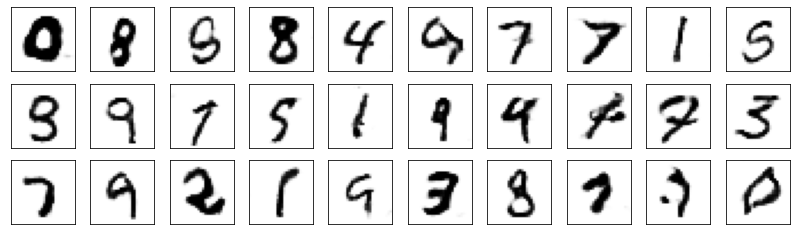

In [5]:
inputs = np.random.normal(size=(30, input_size))
outputs = generator(inputs)

fig, axes = plt.subplots(3, 10, figsize=(14, 4), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(outputs[i], cmap=plt.cm.gray_r)

Not bad for 50 epochs of training!